# SVM

I'll use SVM to match the Dichotomous index of democracy dataset with the Georgetown WPS and World Bank WBL datasets.

In [192]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots as smrp
import sklearn as sk
import country_converter as coco

## Load datasets

In [193]:
# Democracy
dichotomous_df = pd.read_csv('../datasets/processed/democracy/dichotomous/dichotomous-democracy-snapshot.csv', header=0)
# Women's Rights
georgetown_df = pd.read_csv('../datasets/processed/women/georgetown/women-peace-and-security-index.csv', header=0)
world_bank_df = pd.read_csv('../datasets/processed/women/world-bank/women-business-and-the-law-snapshot.csv', header=0)

In [194]:
print(dichotomous_df.info())
print(georgetown_df.info())
print(world_bank_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso3                      191 non-null    object 
 1   country                   191 non-null    object 
 2   ccode                     191 non-null    int64  
 3   abbreviation              191 non-null    object 
 4   abbreviation_undp         191 non-null    object 
 5   democracy                 191 non-null    float64
 6   democracy_trans           191 non-null    int64  
 7   democracy_breakdowns      191 non-null    int64  
 8   democracy_duration        191 non-null    int64  
 9   democracy_omitteddata     191 non-null    int64  
 10  democracy_femalesuffrage  191 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 16.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 17 columns):
 #   Co

## Merge datasets

In [195]:
# Merge all the datasets and lose the countries that are missing in any of them.
merged_df = dichotomous_df.merge(georgetown_df, on='iso3', how='inner', suffixes=('_f', '_g'))
merged_df = merged_df.merge(world_bank_df, on='iso3', how='inner', suffixes=('', '_w'))

print(f"Countries in Dichotomous Democracy: {len(dichotomous_df)}")
print(f"Countries in Georgetown: {len(georgetown_df)}")
print(f"Countries in World Bank: {len(world_bank_df)}")
print(f"Countries in all the datasets: {len(merged_df)}")

Countries in Dichotomous Democracy: 191
Countries in Georgetown: 177
Countries in World Bank: 190
Countries in all the datasets: 169


In [196]:
merged_df.head()

iso3                 country_f  ccode abbreviation abbreviation_undp  \
0  USA  UNITED STATES OF AMERICA      2          USA               USA   
1  CAN                    CANADA     20          CAN               CAN   
2  HTI                     HAITI     41          HTI               HAI   
3  DOM        DOMINICAN REPUBLIC     42          DOM               DOM   
4  JAM                   JAMAICA     51          JAM               JAM   

   democracy  democracy_trans  democracy_breakdowns  democracy_duration  \
0        1.0                0                     0                 206   
1        1.0                0                     0                 139   
2        0.0                0                     0                 186   
3        1.0                0                     0                  40   
4        1.0                0                     0                  44   

   democracy_omitteddata  ...  equal_property_rights  \
0                      1  ...                   True   
1                      1  ...                   True   
2                      0  ...                  False   
3                      1  ...                   True   
4                      1  ...                   True   

   equal_inheritance_children equal_inheritance_spouses  \
0                        True                      True   
1                        True                      True   
2                        True                      True   
3                        True                      True   
4                        True                      True   

   equal_asset_admin_marriage  value_nonmonetary_contributions  pension  \
0                        True                             True       75   
1                        True                             True      100   
2                       False                             True       75   
3                        True                             True       75   
4                        True                             True       75   

   equal_pension_age_full  equal_pension_age_partial  equal_retirement_age  \
0                    True                       True                  True   
1                    True                       True                  True   
2                    True                       True                  True   
3                    True                       True                  True   
4                    True                       True                  True   

   pension_credit_childcare  
0                     False  
1                      True  
2                     False  
3                     False  
4                     False  

[5 rows x 78 columns]

In [197]:
predictors = ["iso3", "country", "democracy", "education", "employment", "financial_inclusion", "cell_phone_use", "parliamentary_representation", "pension", "absence_of_legal_discrimination",
              "maternal_mortality_ratio","son_bias","intimate_partner_violence_","community_safety","political_violence_targeting_women","proximity_to_conflict"]

X=merged_df[predictors]
y=merged_df["democracy"]

## Pairplot

The pairplot grouping by democracy should show us if some predictors have different correlations for democracies and non-democracies.

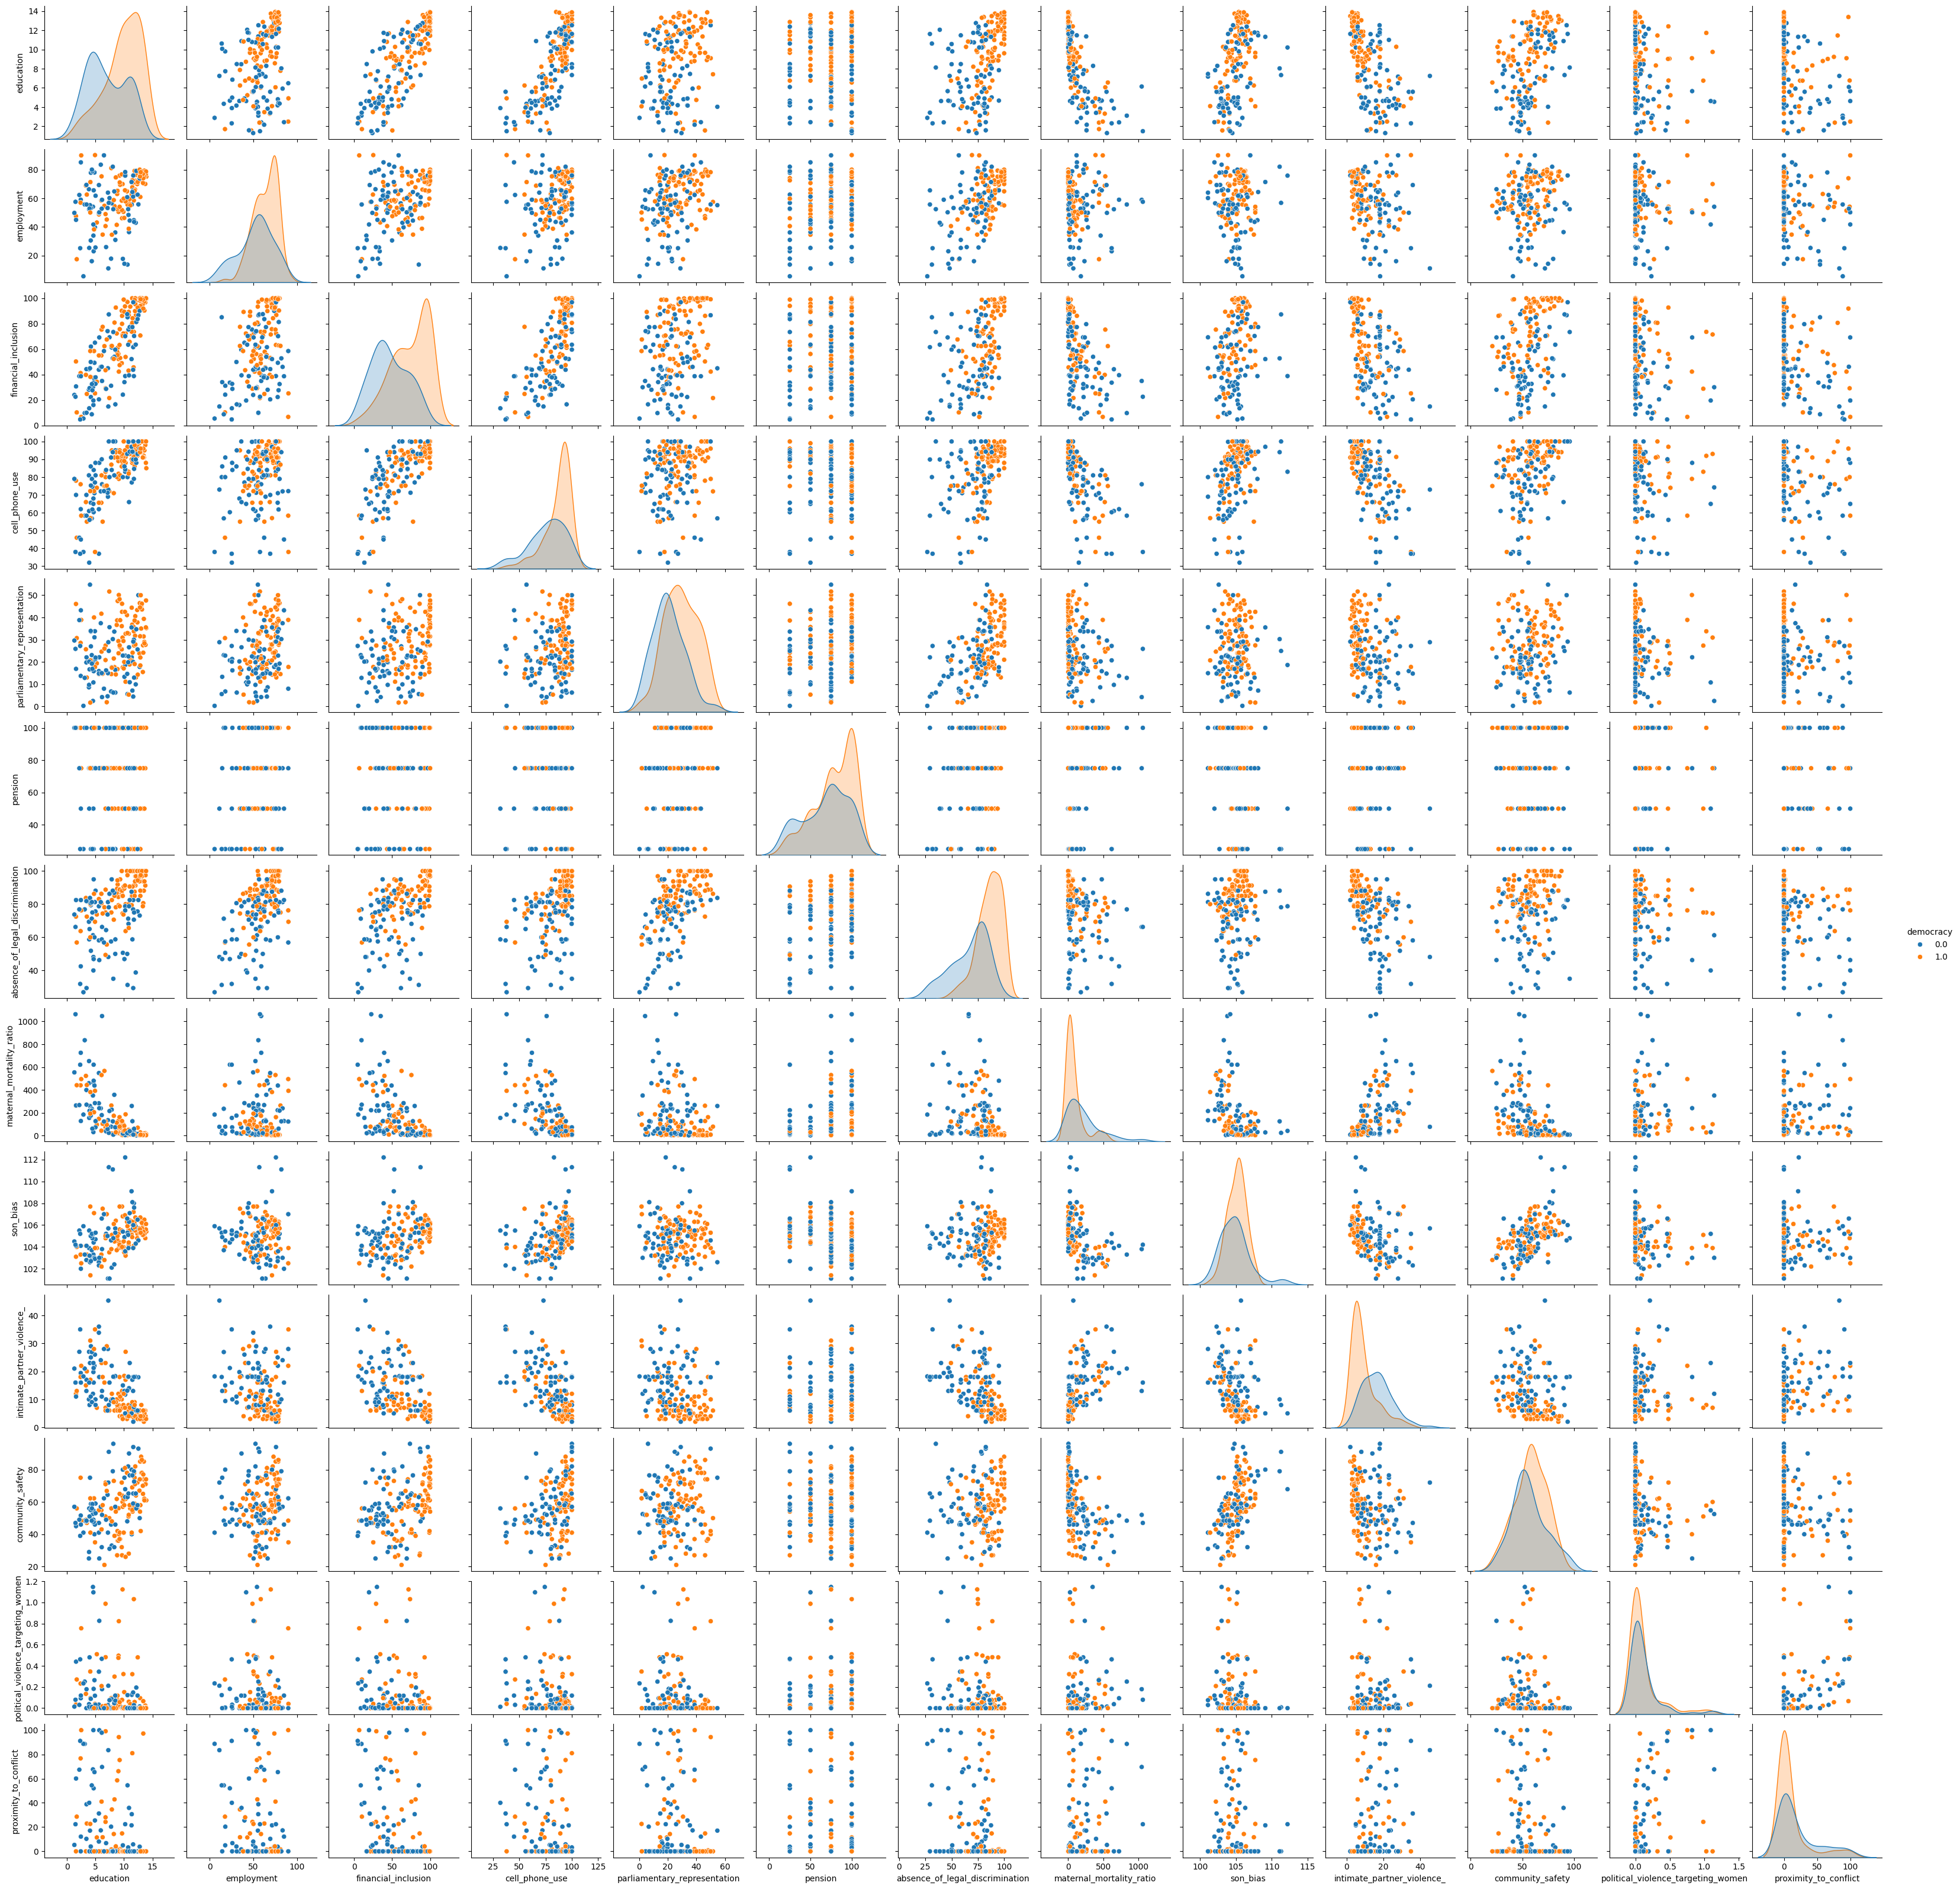

In [198]:
X_with_y=X.copy()
X_with_y["democracy"]=y
sns.pairplot(X_with_y, hue='democracy')
plt.show()

From this pairplot we see that financial_inclusion and education have clearly different values for democratic and non-democratic countries.

On a minor note, other predictors like "parliamentary_representation", "absence_of_legal_discrimination", "intimate_partner_violence_", and "pension" show a clear difference between democratic and non-democratic countries.

Regarding correlations, we see that democratic countries have a combination of higher "absence_of_legal_discrimination" with lower "intimate_partner_violence_"

## SVM Calculation

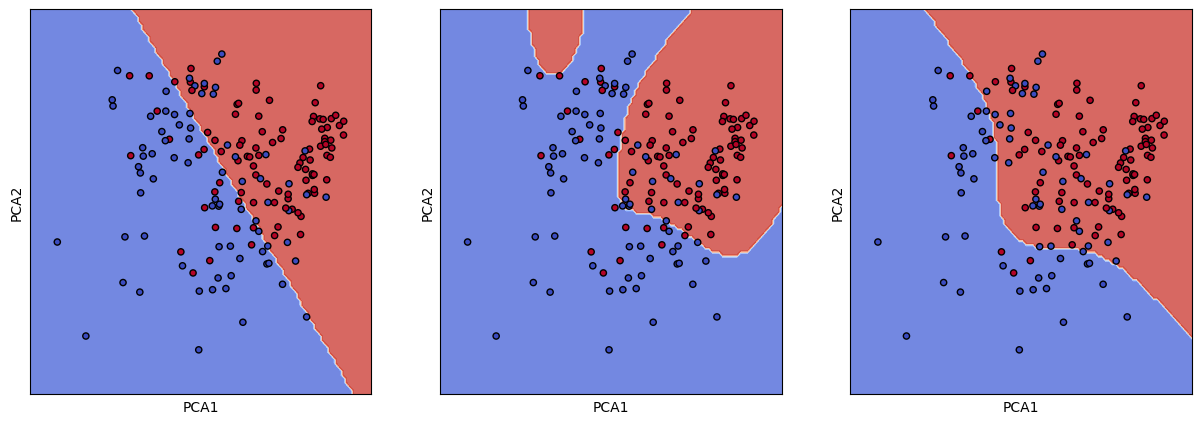

In [199]:
X_only_numeric = X.drop(columns=["iso3", "country","democracy"])

scaler = sk.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X_only_numeric)
pca = sk.decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

C = 10.0
models = [
    sk.svm.SVC(kernel="linear", C=C),
    sk.svm.SVC(kernel="rbf", C=C),
    sk.svm.SVC(kernel="poly", degree=3, gamma="auto", C=C)
]
fitted_models = []
for model in models:
    model = model.fit(X_pca, y)
    fitted_models.append(model)

fig, sub = plt.subplots(1, 3, figsize=(15, 5))
ax = sub.flatten()

X0, X1 = X_pca[:, 0], X_pca[:, 1]

for model, ax in zip(models, sub.flatten()):
    disp = sk.inspection.DecisionBoundaryDisplay.from_estimator(
        model,
        X_pca,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel="PCA1",
        ylabel="PCA2",
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())

This shows a clear separation between democratic and non-democratic countries by making use of the Georgetown and World Bank datasets.

I'll print the confusion matrix.

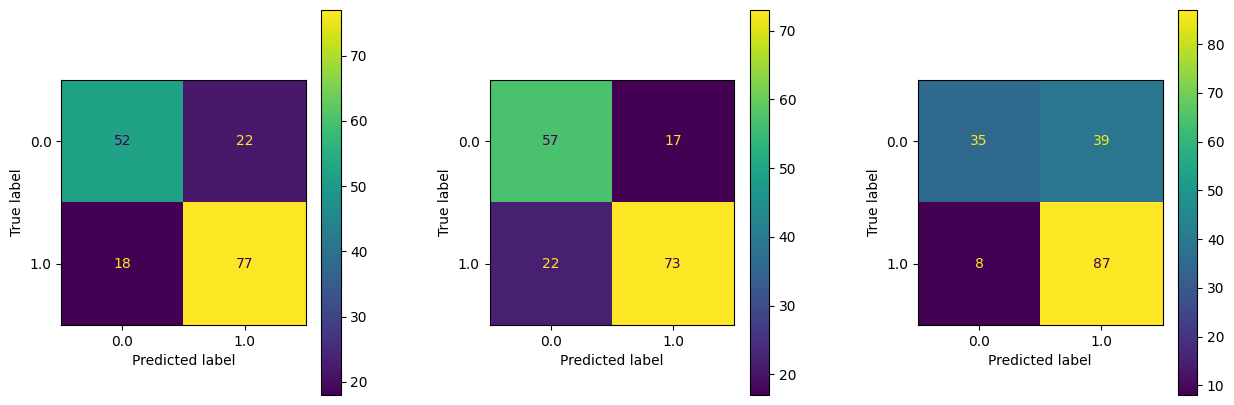

In [200]:
y_preds = []
for model in models:
    y_pred = model.predict(X_pca)
    y_preds.append(y_pred)

fig, sub = plt.subplots(1, 3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i, y_pred in enumerate(y_preds):
  ax = sub.flatten()[i]
  cm = sk.metrics.confusion_matrix(y, y_pred)
  disp = sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
  disp.plot(ax=ax, cmap='viridis')

plt.show()

The Linear and Radial kernel have a similar performance. Given that the linear kernel is more "explainable", I'll use it.

I'll train a linear SVM with the full dataset and evaluate its performance.

In [201]:
linear_model = sk.svm.SVC(kernel='linear', C=10.0)
linear_model.fit(X_scaled, y)

feature_importance = pd.DataFrame({
    'Feature': X_only_numeric.columns,
    'Importance': np.abs(linear_model.coef_[0])
})

feature_importance = feature_importance.sort_values('Importance', ascending=False)

print(feature_importance)


                               Feature  Importance
6      absence_of_legal_discrimination    0.933069
2                  financial_inclusion    0.763390
9           intimate_partner_violence_    0.627499
3                       cell_phone_use    0.593878
10                    community_safety    0.440298
11  political_violence_targeting_women    0.333776
0                            education    0.240066
5                              pension    0.219835
4         parliamentary_representation    0.190485
7             maternal_mortality_ratio    0.183080
1                           employment    0.140068
12               proximity_to_conflict    0.074417
8                             son_bias    0.001462


Each feature is multiplied by the coefficient, if the result is positive, the country is classified as democratic, otherwise it is non-democratic.

In [202]:
decision_values = linear_model.decision_function(X_scaled)

y_pred = (decision_values > 0).astype(int)

decision_df = pd.DataFrame({
    'Decision_Value': decision_values,
    'Predicted': y_pred,
    'Democracy': y,
    'Country': X['country']
})

# print(decision_df)

misclassified = decision_df[decision_df['Democracy'] != decision_df['Predicted']]

# False positives
false_positives = misclassified[misclassified['Predicted'] == 1]

# False negatives
false_negatives = misclassified[misclassified['Predicted'] == 0]

print("\nFalse positives:")
print(false_positives['Country'].to_string(index=False))
print("\nFalse negatives:")
print(false_negatives['Country'].to_string(index=False))


False positives:
     Venezuela, RB
Russian Federation
           Belarus
           Armenia
      Burkina Faso
             Gabon
        Mozambique
          Zimbabwe
           Namibia
           Comoros
        Kazakhstan
          Maldives
           Lao PDR
         Singapore

False negatives:
        Barbados
          Panama
            Mali
         Senegal
           Benin
           Niger
    Sierra Leone
           Ghana
           Kenya
         Burundi
          Malawi
        Botswana
      Madagascar
      Bangladesh
     Philippines
       Indonesia
     Timor-Leste
Papua New Guinea
         Vanuatu


When we like at the false positives (Countries that are classified as democratic but are not), we see similar names to the ones in the linear regression. Many of them are countries with modern economies (Or that had a modern economy in the past), but become dictatorships.

When looking at the false negatives (Countries that are classified as non-democratic but are democratic), we see many countries with low economic development, most of them African countries.

# SVM with World Bank data

The Georgetown dataset is based on surveys that analyze the status of women but it doesn't compare it to the situation of men. This could lead to a bias in the result, given than more democratic countries are more likely to have better rights for women, as well as men.

## Merge datasets

In [203]:
dichotomous_df = pd.read_csv('../datasets/processed/democracy/dichotomous/dichotomous-democracy-snapshot.csv', header=0)
world_bank_df = pd.read_csv('../datasets/processed/women/world-bank/women-business-and-the-law-snapshot.csv', header=0)

merged_df = dichotomous_df.merge(world_bank_df, on='iso3', how='inner', suffixes=('_f', '_g'))

print(f"Countries in Dichotomous Democracy: {len(dichotomous_df)}")
print(f"Countries in World Bank: {len(world_bank_df)}")
print(f"Countries in all the datasets: {len(merged_df)}")

Countries in Dichotomous Democracy: 191
Countries in World Bank: 190
Countries in all the datasets: 183


In [204]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 62 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   iso3                                 183 non-null    object 
 1   country_f                            183 non-null    object 
 2   ccode                                183 non-null    int64  
 3   abbreviation                         183 non-null    object 
 4   abbreviation_undp                    183 non-null    object 
 5   democracy                            183 non-null    float64
 6   democracy_trans                      183 non-null    int64  
 7   democracy_breakdowns                 183 non-null    int64  
 8   democracy_duration                   183 non-null    int64  
 9   democracy_omitteddata                183 non-null    int64  
 10  democracy_femalesuffrage             183 non-null    int64  
 11  country_g                       

In [205]:
predictors = ["iso3", "wbl_index", "mobility", "workplace", "pay", "marriage", "parenthood", "entrepreneurship", "assets", "pension"]

X=merged_df[predictors]
y=merged_df["democracy"]

## Pairplot

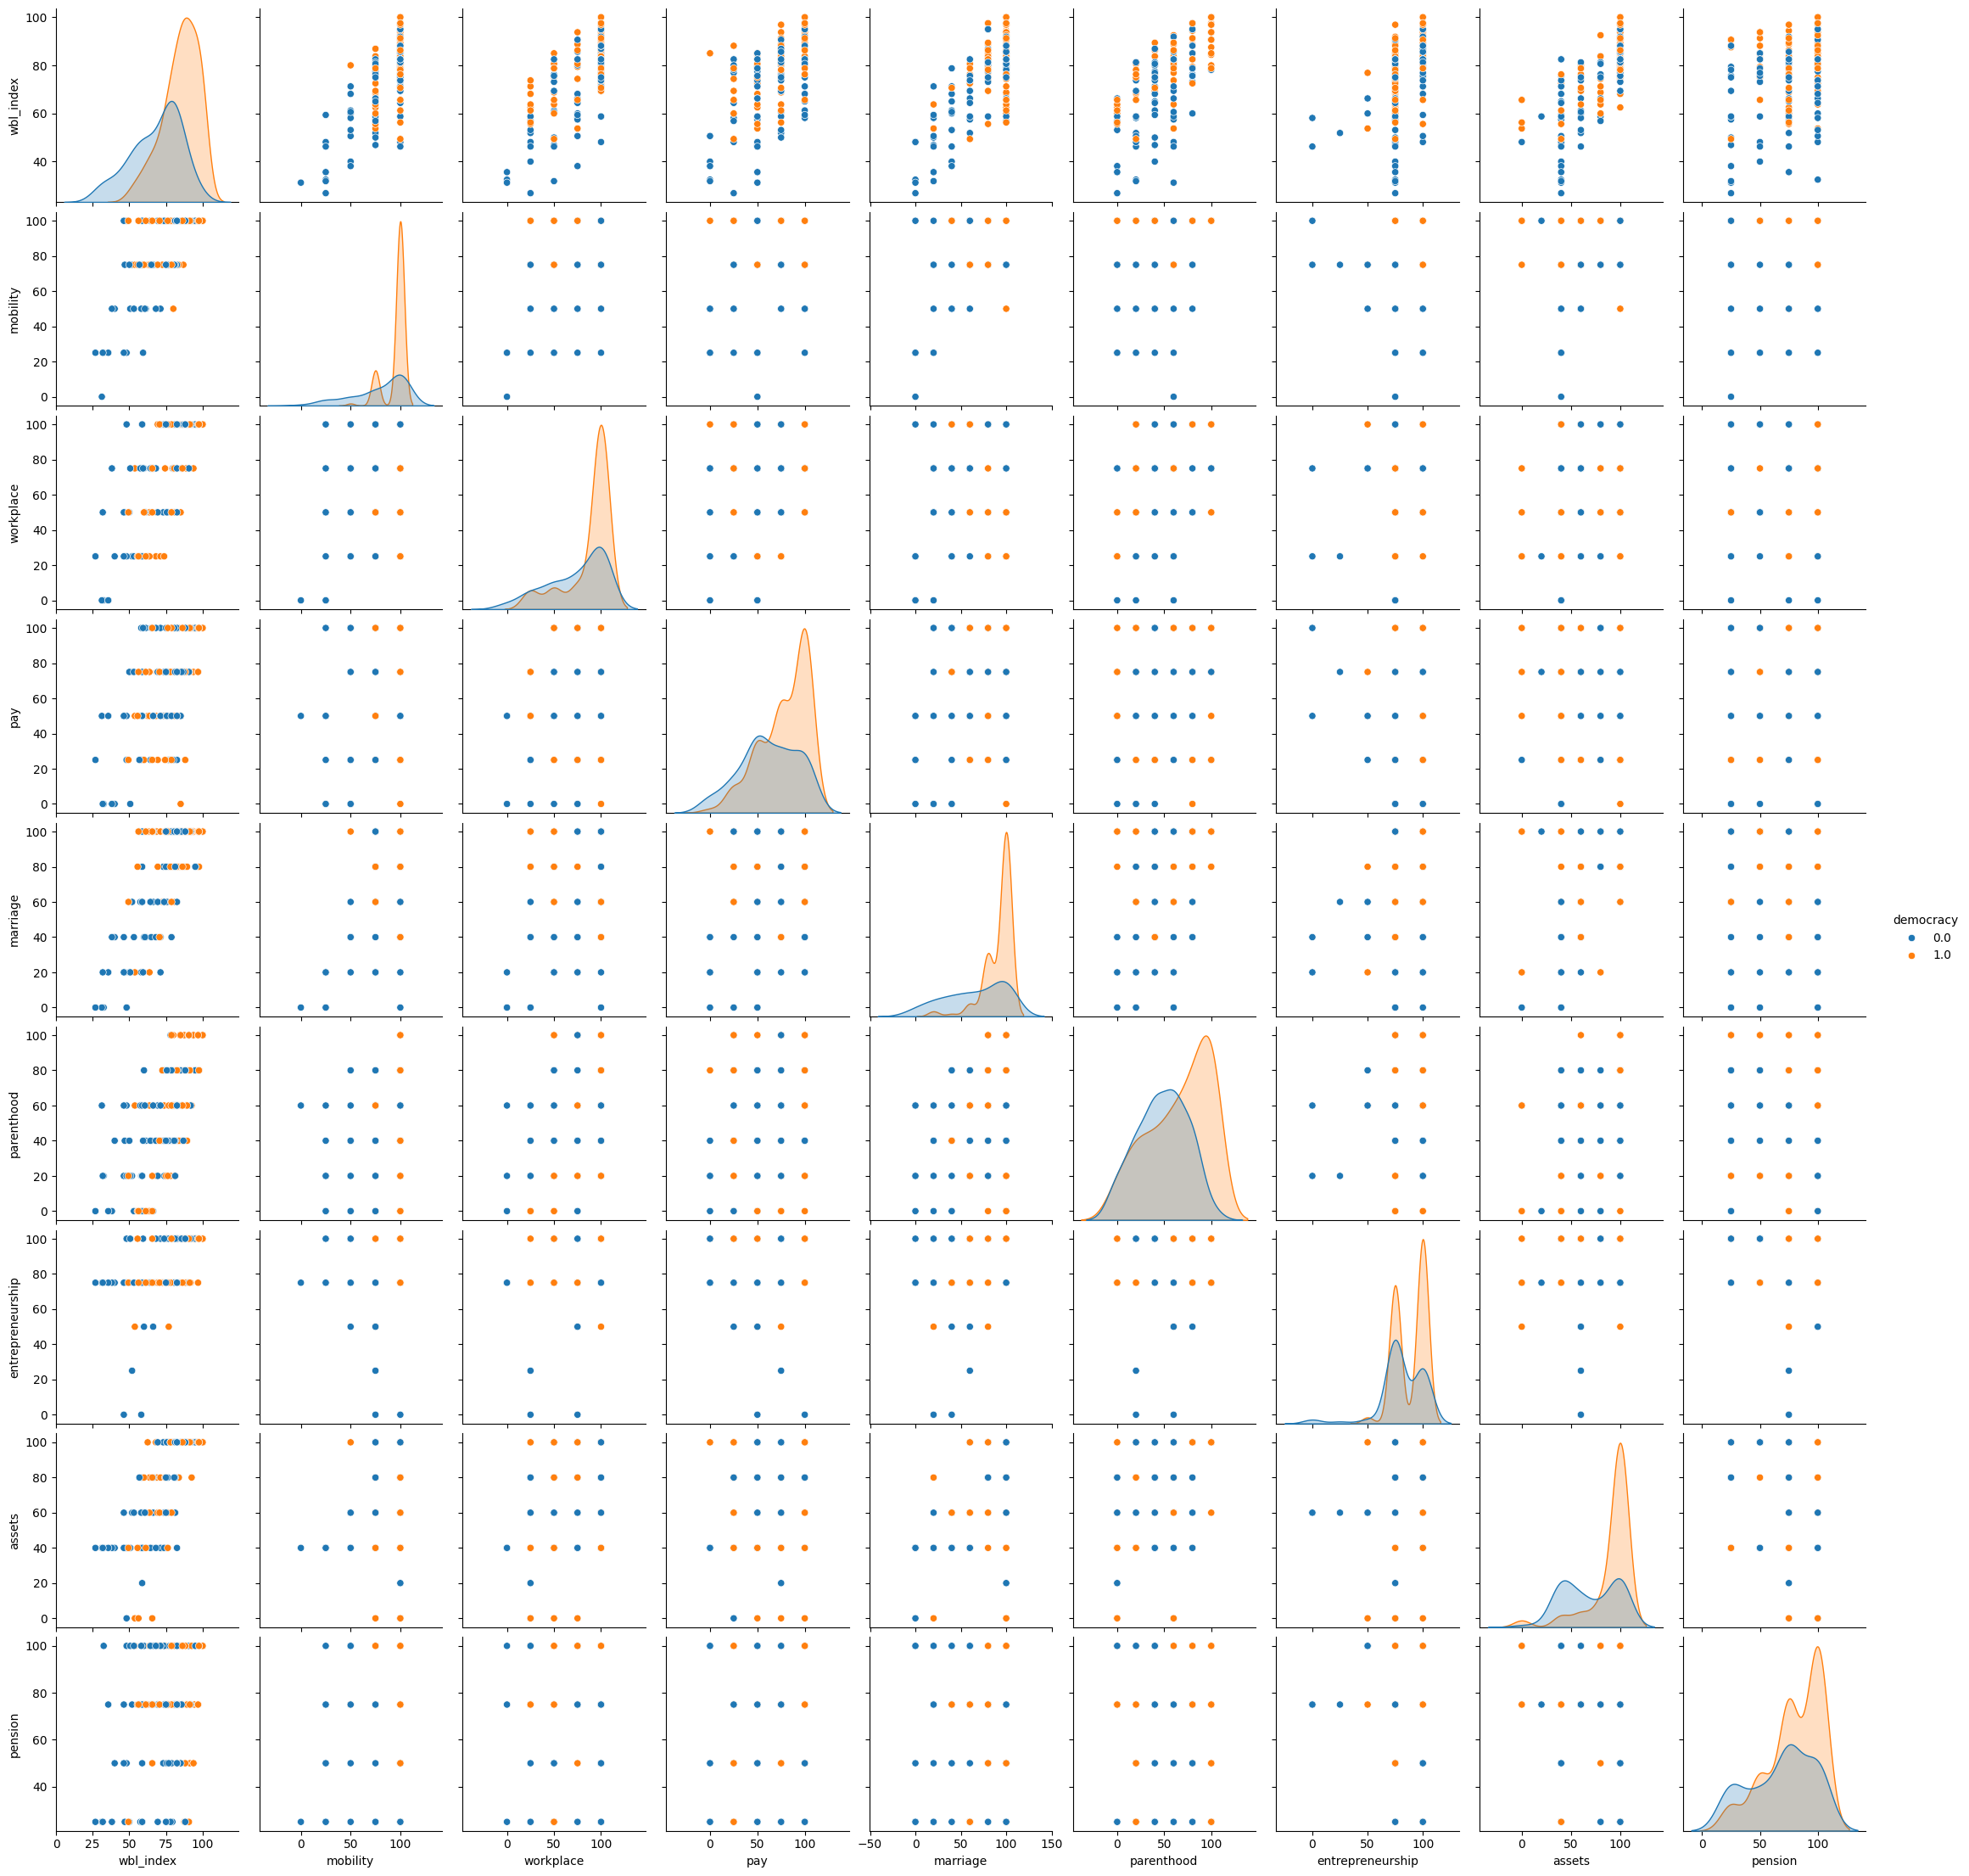

In [206]:
X_with_y=X.copy()
X_with_y["democracy"]=y
sns.pairplot(X_with_y, hue='democracy')
plt.show()

## SVM Calculation

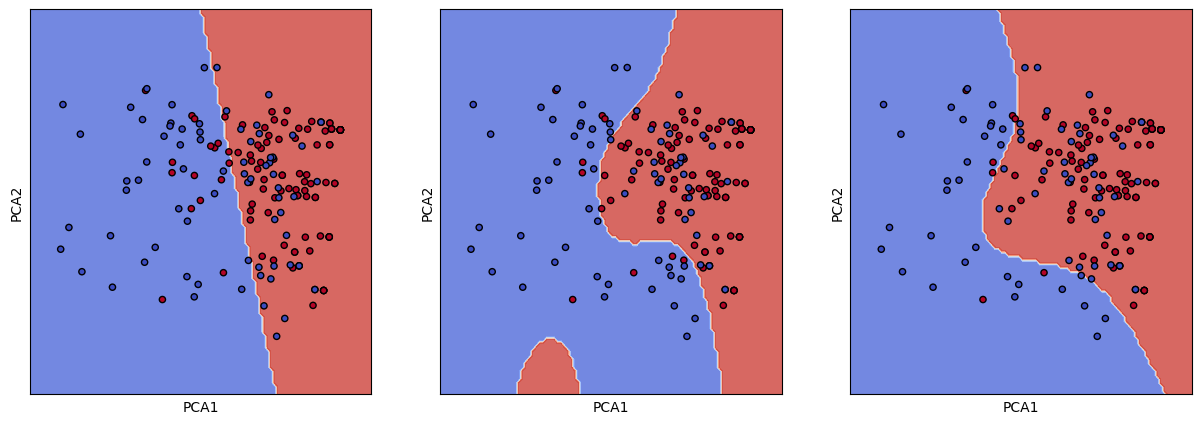

In [207]:
X_only_numeric = X.drop(columns=["iso3"])

scaler = sk.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X_only_numeric)
pca = sk.decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

C = 10.0
models = [
    sk.svm.SVC(kernel="linear", C=C),
    sk.svm.SVC(kernel="rbf", C=C),
    sk.svm.SVC(kernel="poly", degree=3, gamma="auto", C=C)
]
fitted_models = []
for model in models:
    model = model.fit(X_pca, y)
    fitted_models.append(model)

fig, sub = plt.subplots(1, 3, figsize=(15, 5))
ax = sub.flatten()

X0, X1 = X_pca[:, 0], X_pca[:, 1]

for model, ax in zip(models, sub.flatten()):
    disp = sk.inspection.DecisionBoundaryDisplay.from_estimator(
        model,
        X_pca,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel="PCA1",
        ylabel="PCA2",
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())

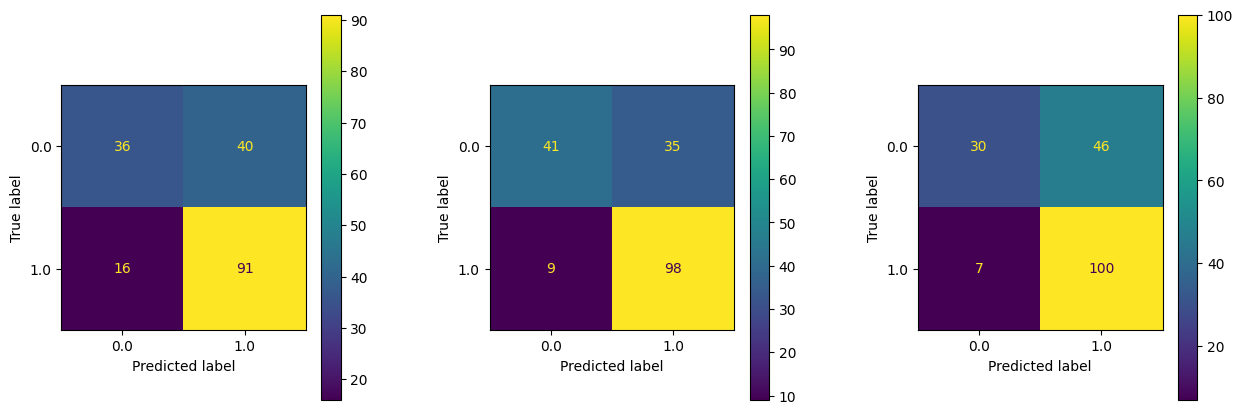

In [208]:
y_preds = []
for model in models:
    y_pred = model.predict(X_pca)
    y_preds.append(y_pred)

fig, sub = plt.subplots(1, 3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i, y_pred in enumerate(y_preds):
  ax = sub.flatten()[i]
  cm = sk.metrics.confusion_matrix(y, y_pred)
  disp = sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
  disp.plot(ax=ax, cmap='viridis')

plt.show()

All the predictors are bad and have too many false positives. I'll look at linear SVM.

In [209]:
linear_model = sk.svm.SVC(kernel='linear', C=10.0)
linear_model.fit(X_scaled, y)

feature_importance = pd.DataFrame({
    'Feature': X_only_numeric.columns,
    'Importance': np.abs(linear_model.coef_[0])
})

feature_importance = feature_importance.sort_values('Importance', ascending=False)

print(feature_importance)


            Feature  Importance
4          marriage    0.765740
0         wbl_index    0.249730
8           pension    0.197639
1          mobility    0.157526
3               pay    0.128709
7            assets    0.091948
2         workplace    0.052292
6  entrepreneurship    0.032418
5        parenthood    0.016960


In [210]:
decision_values = linear_model.decision_function(X_scaled)

y_pred = (decision_values > 0).astype(int)

decision_df = pd.DataFrame({
    'Decision_Value': decision_values,
    'Predicted': y_pred,
    'Democracy': y,
    'Country': X['iso3']
})

# print(decision_df)

misclassified = decision_df[decision_df['Democracy'] != decision_df['Predicted']]
correctly_classified = decision_df[decision_df['Democracy'] == decision_df['Predicted']]

# False positives
false_positives = misclassified[misclassified['Predicted'] == 1]
# False negatives
false_negatives = misclassified[misclassified['Predicted'] == 0]

# True positives
true_positives = correctly_classified[correctly_classified['Predicted'] == 1]
# True negatives
true_negatives = correctly_classified[correctly_classified['Predicted'] == 0]

cc = coco.CountryConverter()
print("\nFalse positives:")
print(', '.join(cc.pandas_convert(series=false_positives['Country'], to='name_official', not_found=None)))
print("\nFalse negatives:")
print(', '.join(cc.pandas_convert(series=false_negatives['Country'], to='name_official', not_found=None)))
print("\nTrue positives:")
print(', '.join(cc.pandas_convert(series=true_positives['Country'], to='name_official', not_found=None)))
print("\nTrue negatives:")
print(', '.join(cc.pandas_convert(series=true_negatives['Country'], to='name_official', not_found=None)))


False positives:
Bolivarian Republic of Venezuela, Russian Federation, Republic of Belarus, Republic of Armenia, Republic of Azerbaijan, Republic of Côte d'Ivoire, Burkina Faso, Republic of Liberia, Togolese Republic, Federal Republic of Nigeria, Gabonese Republic, Central African Republic, Republic of Uganda, United Republic of Tanzania, Republic of Rwanda, Federal Democratic Republic of Ethiopia, Republic of Angola, Republic of Mozambique, Republic of Zambia, Republic of Zimbabwe, Republic of Namibia, Republic of Seychelles, United Arab Emirates, Republic of Tajikistan, Kyrgyz Republic, Republic of Uzbekistan, Republic of Kazakhstan, People's Republic of China, Kingdom of Bhutan, Federal Democratic Republic of Nepal, Kingdom of Cambodia, Lao People's Democratic Republic, Socialist Republic of Vietnam, Republic of Singapore, Solomon Islands, Republic of Fiji, Kingdom of Tonga, Independent State of Samoa

False negatives:
Republic of Mali, Republic of Senegal, Republic of Niger, Repub

When it's based on the World Bank dataset, the classifier has a bias towards defining non-democratic countries as democratic.

# SVM with World Bank and Religious Diversity Data

In [211]:
dichotomous_df = pd.read_csv('../datasets/processed/democracy/dichotomous/dichotomous-democracy-snapshot.csv', header=0)
world_bank_df = pd.read_csv('../datasets/processed/women/world-bank/women-business-and-the-law-snapshot.csv', header=0)
religious_diversity_df = pd.read_csv('../datasets/processed/religion/pew-research-center-religion-diversity/religious-diversity-index-extended.csv', header=0)

merged_df = dichotomous_df.merge(world_bank_df, on='iso3', how='inner', suffixes=('_f', '_g'))
merged_df = merged_df.merge(religious_diversity_df, on='iso3', how='inner', suffixes=('_f', '_g'))

print(f"Countries in Dichotomous Democracy: {len(dichotomous_df)}")
print(f"Countries in World Bank: {len(world_bank_df)}")
print(f"Countries in Religious Diversity: {len(religious_diversity_df)}")
print(f"Countries in all the datasets: {len(merged_df)}")
merged_df.head()

Countries in Dichotomous Democracy: 191
Countries in World Bank: 190
Countries in Religious Diversity: 230
Countries in all the datasets: 183


iso3                 country_f  ccode abbreviation abbreviation_undp  \
0  USA  UNITED STATES OF AMERICA      2          USA               USA   
1  CAN                    CANADA     20          CAN               CAN   
2  BHS                   BAHAMAS     31          BHS               BHS   
3  HTI                     HAITI     41          HTI               HAI   
4  DOM        DOMINICAN REPUBLIC     42          DOM               DOM   

   democracy  democracy_trans  democracy_breakdowns  democracy_duration  \
0        1.0                0                     0                 206   
1        1.0                0                     0                 139   
2        1.0                0                     0                  33   
3        0.0                0                     0                 186   
4        1.0                0                     0                  40   

   democracy_omitteddata  ...  population dominant_religion maj_christian  \
0                      1  ...   310380000         christian             1   
1                      1  ...    34020000         christian             1   
2                      1  ...      340000         christian             1   
3                      0  ...     9990000         christian             1   
4                      1  ...     9930000         christian             1   

   maj_muslim  maj_unaffiliated  maj_hindu  maj_buddhist  maj_folk  maj_other  \
0           0                 0          0             0         0          0   
1           0                 0          0             0         0          0   
2           0                 0          0             0         0          0   
3           0                 0          0             0         0          0   
4           0                 0          0             0         0          0   

   maj_jewish  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 82 columns]

In [212]:
predictors = ["iso3", "wbl_index", "mobility", "workplace", "pay", "marriage", "parenthood", "entrepreneurship", "assets", "pension","rdi","dominant_religion","maj_christian","maj_muslim","maj_unaffiliated","maj_hindu","maj_buddhist","maj_folk","maj_other","maj_jewish"]

X=merged_df[predictors]
y=merged_df["democracy"]

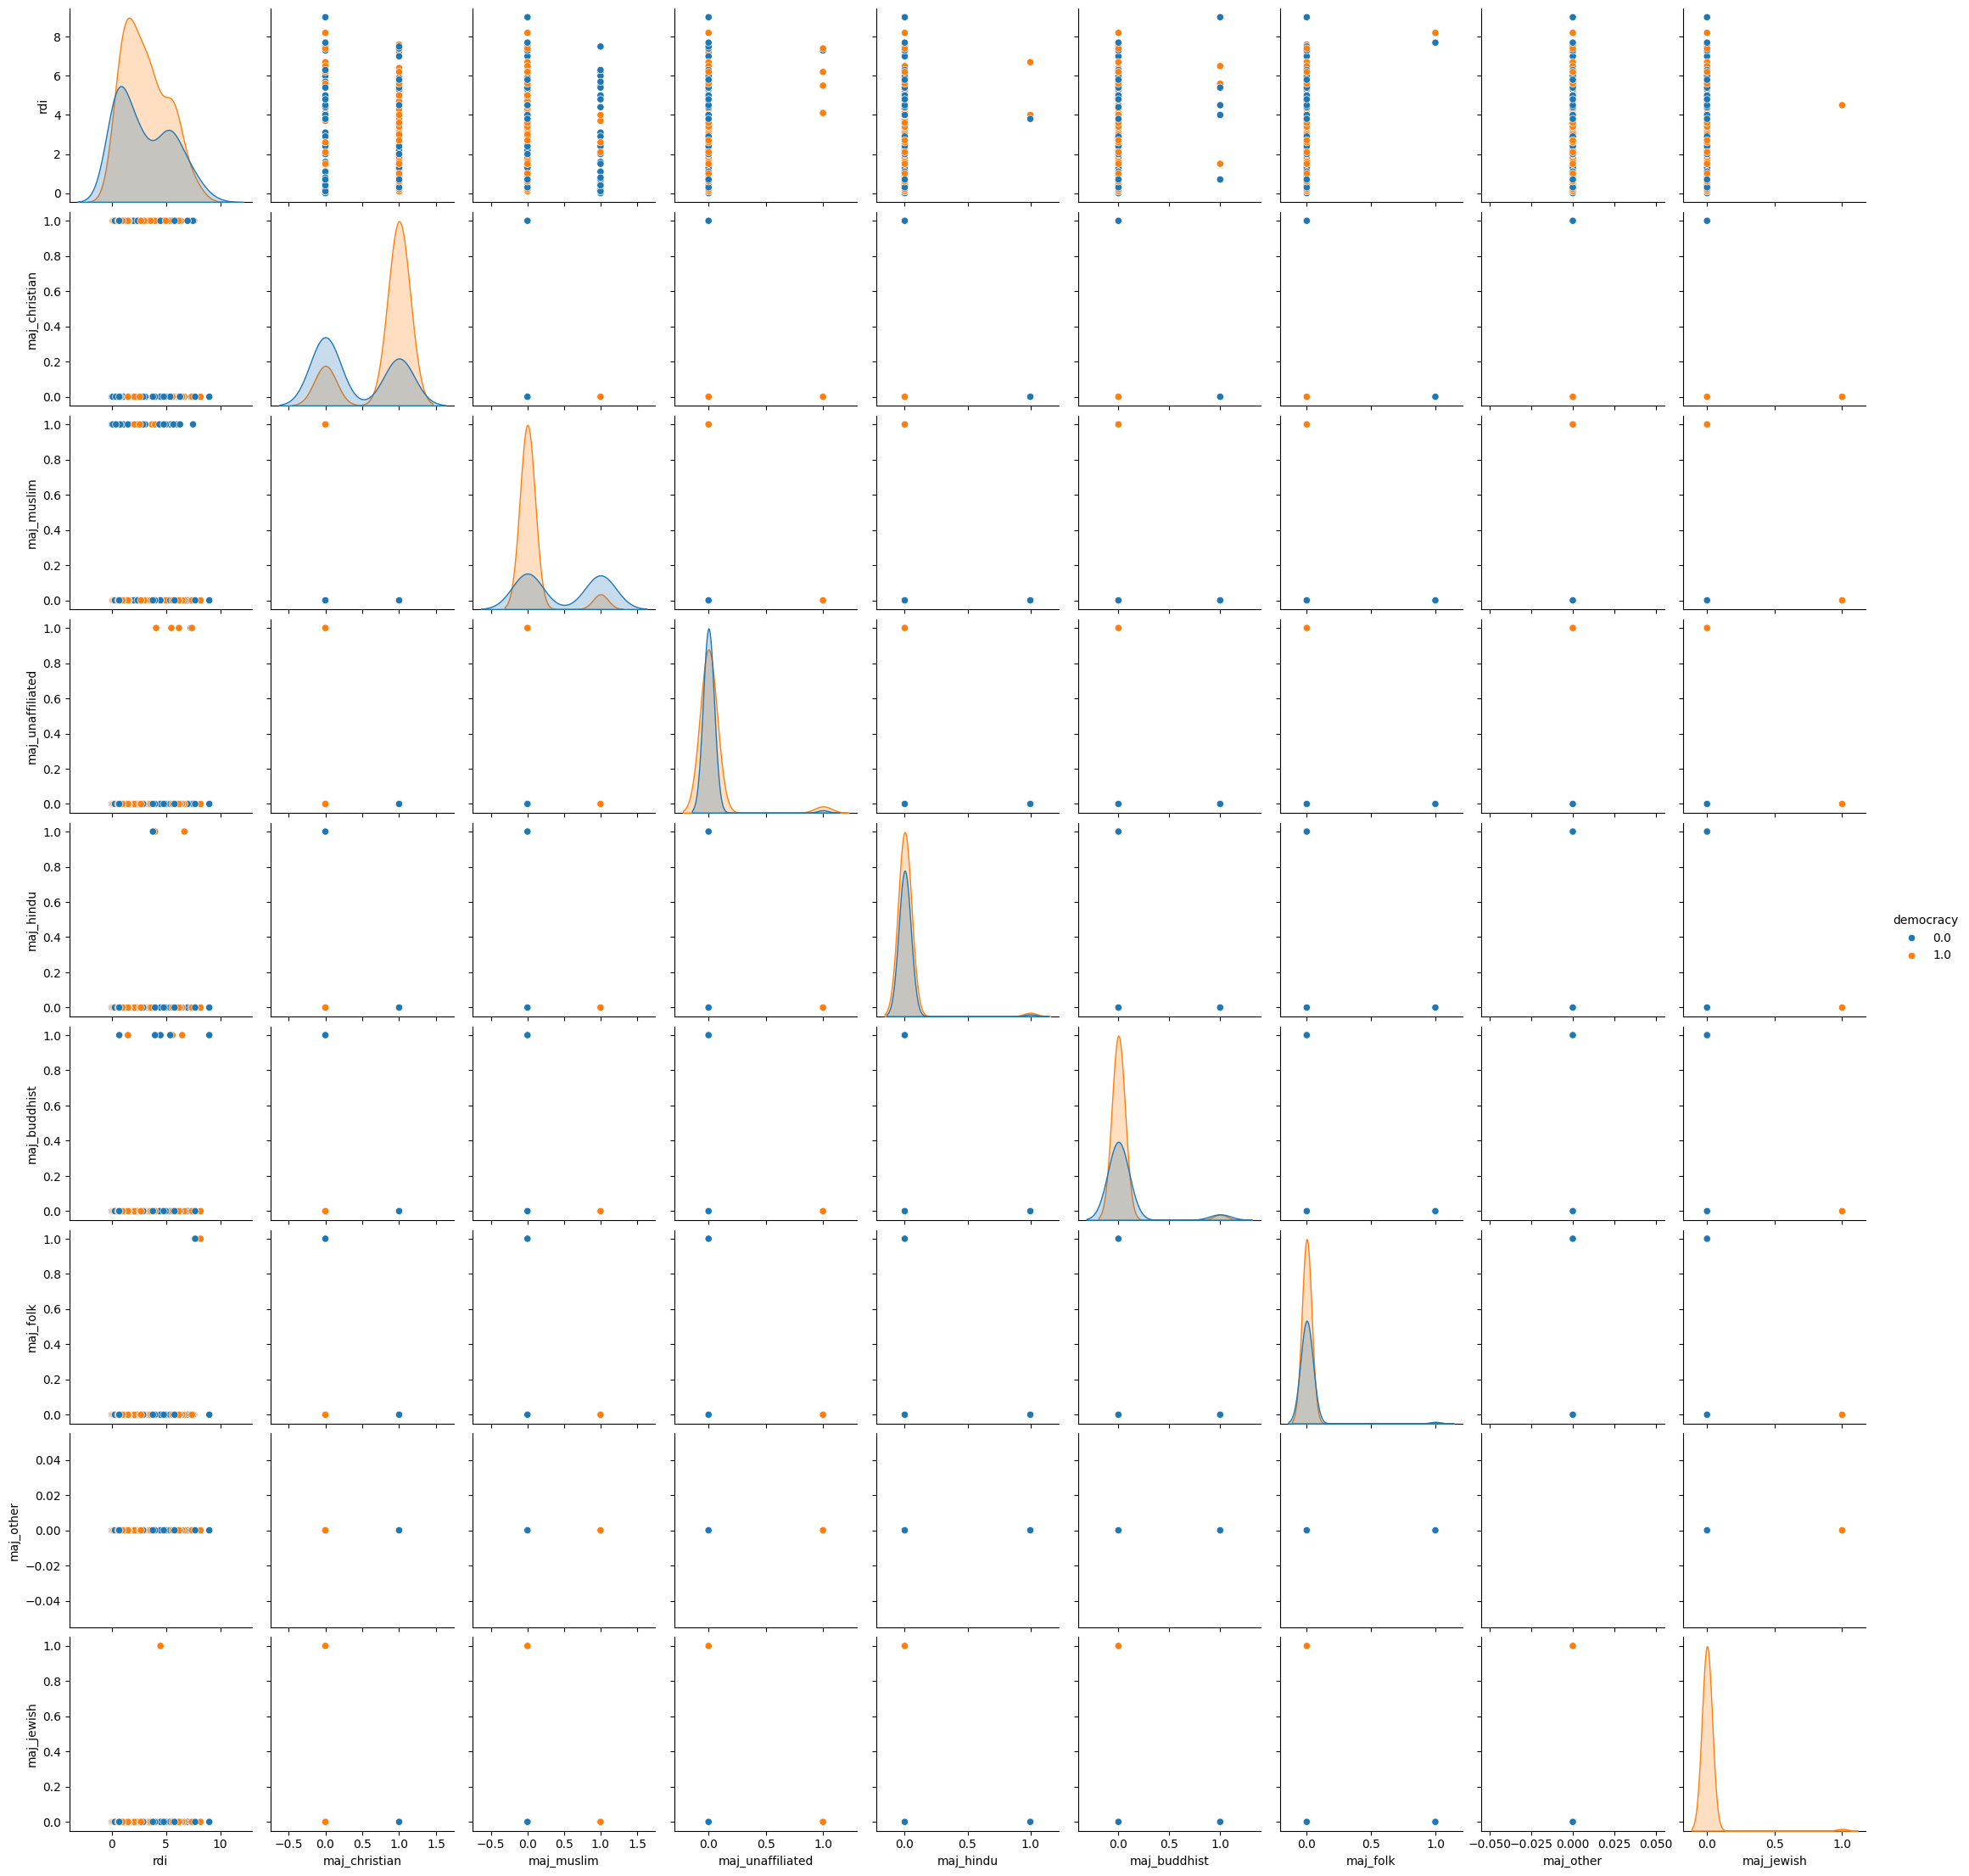

In [213]:
X_with_y=X.copy()
X_with_y["democracy"]=y
X_with_y=X_with_y[["democracy","rdi","maj_christian","maj_muslim","maj_unaffiliated","maj_hindu","maj_buddhist","maj_folk","maj_other","maj_jewish"]]
sns.pairplot(X_with_y, hue='democracy')
plt.show()

We have to look at the second peak. This only adds the information that some of the christian countries are not democratic, while within muslim countries, more are non-democratic than democratic.
Countries with more religious diversity are more likely to be democratic.

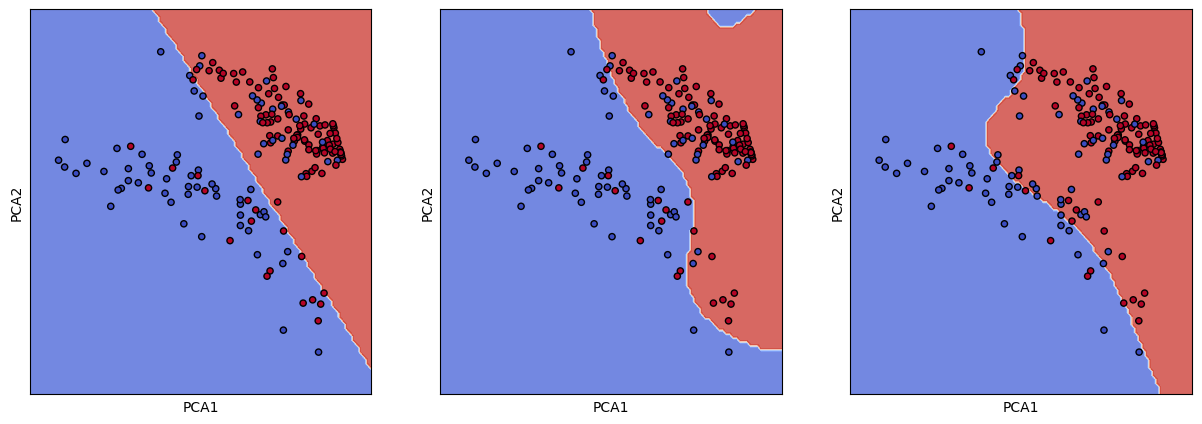

In [214]:
X_only_numeric = X.drop(columns=["iso3","dominant_religion"])

scaler = sk.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X_only_numeric)
pca = sk.decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

C = 10.0
models = [
    sk.svm.SVC(kernel="linear", C=C),
    sk.svm.SVC(kernel="rbf", C=C),
    sk.svm.SVC(kernel="poly", degree=3, gamma="auto", C=C)
]
fitted_models = []
for model in models:
    model = model.fit(X_pca, y)
    fitted_models.append(model)

fig, sub = plt.subplots(1, 3, figsize=(15, 5))
ax = sub.flatten()

X0, X1 = X_pca[:, 0], X_pca[:, 1]

for model, ax in zip(models, sub.flatten()):
    disp = sk.inspection.DecisionBoundaryDisplay.from_estimator(
        model,
        X_pca,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel="PCA1",
        ylabel="PCA2",
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())

This is interesting. Adding the countries religion majorities we see a cluster where the majority are non-democratic and another majority with a mix of democratic and non-democratic countries.

I'll do a PCA of the dataset (Countries based on women's rights and majority religion)

/var/folders/3c/bf3091xd4h9fj5rvqhp6_05r0000gq/T/ipykernel_11114/1572661764.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Text(0, 0.5, 'PC2')

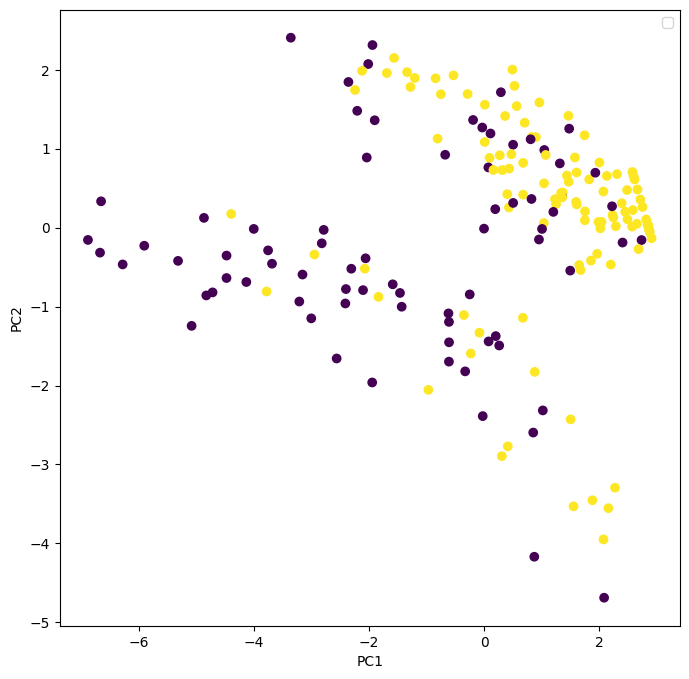

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

This shows that this cluster has a majority of democratic countries.

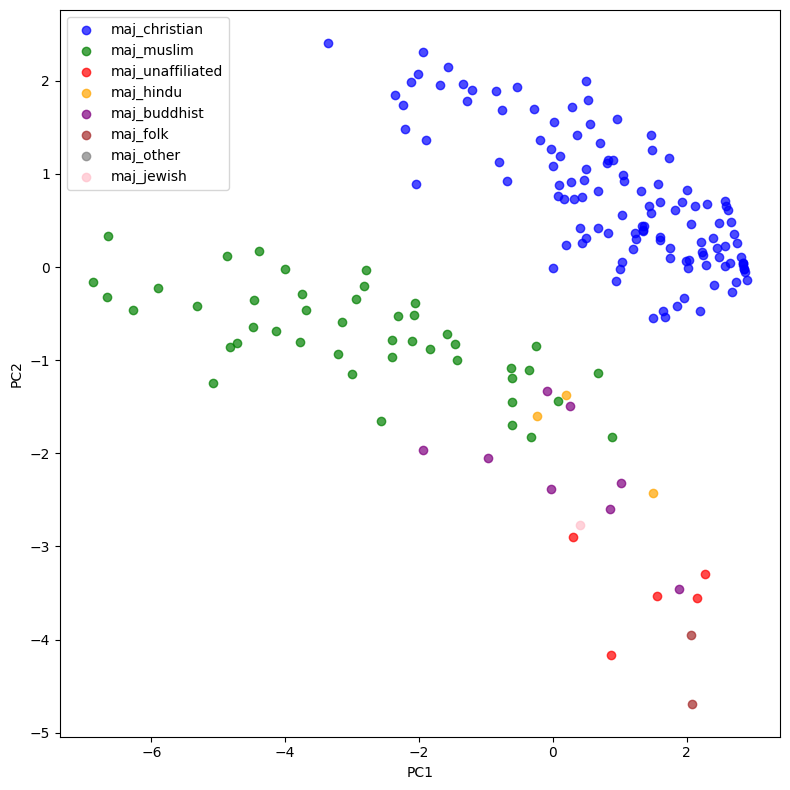

In [216]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

religion_colors = {
    'maj_christian': 'blue',
    'maj_muslim': 'green',
    'maj_unaffiliated': 'red',
    'maj_hindu': 'orange',
    'maj_buddhist': 'purple',
    'maj_folk': 'brown',
    'maj_other': 'gray',
    'maj_jewish': 'pink'
}

for religion, color in religion_colors.items():
    mask = X[religion] == 1
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, label=religion, alpha=0.7)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(loc='upper left')
plt.tight_layout()

In [217]:
# Print the loadings of the first principal component associated with the predictors
loadings = pd.DataFrame(
    {'Predictor': X_only_numeric.columns,
     'Loading': pca.components_[0]
    }
).sort_values(by='Loading', ascending=False)

print("First Principal Component Loadings:")
print(loadings)

loadings = pd.DataFrame(
    {'Predictor': X_only_numeric.columns,
     'Loading': pca.components_[1]
    }
).sort_values(by='Loading', ascending=False)

print("Second Principal Component Loadings:")
print(loadings)

First Principal Component Loadings:
           Predictor   Loading
0          wbl_index  0.422106
4           marriage  0.355669
7             assets  0.351922
1           mobility  0.319808
2          workplace  0.292801
5         parenthood  0.279959
3                pay  0.254275
10     maj_christian  0.254060
6   entrepreneurship  0.209893
9                rdi  0.138757
8            pension  0.095921
12  maj_unaffiliated  0.045273
15          maj_folk  0.041191
13         maj_hindu  0.011945
17        maj_jewish  0.005750
14      maj_buddhist  0.005015
16         maj_other  0.000000
11        maj_muslim -0.315326
Second Principal Component Loadings:
           Predictor   Loading
10     maj_christian  0.562749
8            pension  0.276819
4           marriage  0.075435
3                pay  0.061062
16         maj_other -0.000000
1           mobility -0.036893
0          wbl_index -0.050959
7             assets -0.059576
17        maj_jewish -0.118837
13         maj_hindu -0.1343

Now I'll make a PCA based only on the world bank dataset but coloring the countries by their majority religion.

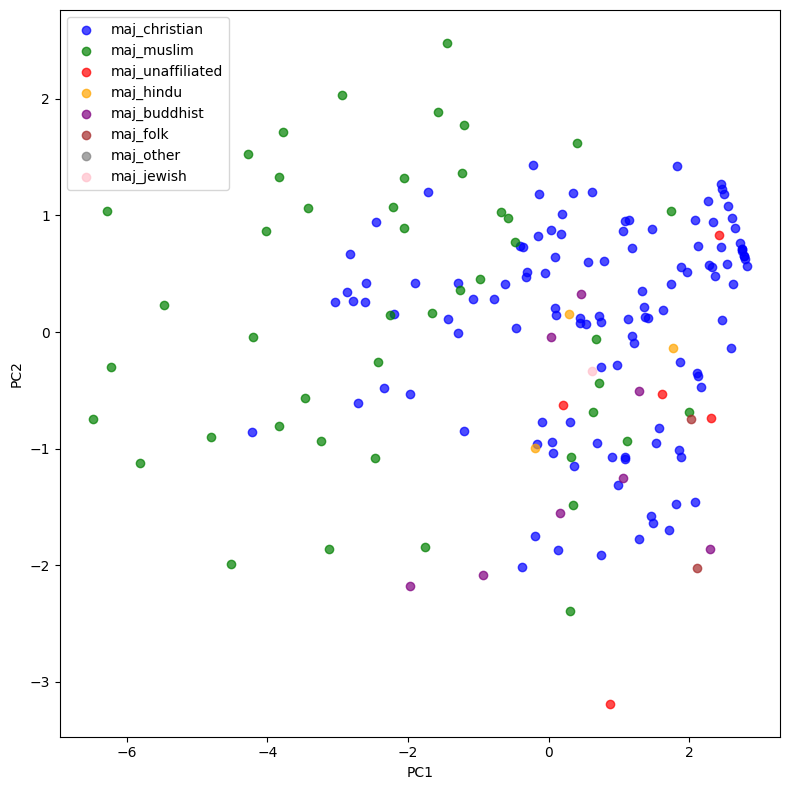

In [218]:
X_only_worldbank = X.drop(columns=["iso3","dominant_religion","maj_christian","maj_muslim","maj_unaffiliated","maj_hindu","maj_buddhist","maj_folk","maj_other","maj_jewish"])

scaler = sk.preprocessing.StandardScaler()
X_worldbank_scaled = scaler.fit_transform(X_only_worldbank)
pca = sk.decomposition.PCA(n_components=2)
X_worldbank_pca = pca.fit_transform(X_worldbank_scaled)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

religion_colors = {
    'maj_christian': 'blue',
    'maj_muslim': 'green',
    'maj_unaffiliated': 'red',
    'maj_hindu': 'orange',
    'maj_buddhist': 'purple',
    'maj_folk': 'brown',
    'maj_other': 'gray',
    'maj_jewish': 'pink'
}

for religion, color in religion_colors.items():
    mask = X[religion] == 1
    ax.scatter(X_worldbank_pca[mask, 0], X_worldbank_pca[mask, 1], c=color, label=religion, alpha=0.7)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(loc='upper left')
plt.tight_layout()

In [219]:
# Print the loadings of the first principal component associated with the predictors
loadings = pd.DataFrame(
    {'Predictor': X_only_worldbank.columns,
     'Loading': pca.components_[0]
    }
).sort_values(by='Loading', ascending=False)

print("First Principal Component Loadings:")
print(loadings)

loadings = pd.DataFrame(
    {'Predictor': X_only_worldbank.columns,
     'Loading': pca.components_[1]
    }
).sort_values(by='Loading', ascending=False)

print("Second Principal Component Loadings:")
print(loadings)

First Principal Component Loadings:
          Predictor   Loading
0         wbl_index  0.462218
7            assets  0.370127
4          marriage  0.361086
1          mobility  0.346538
2         workplace  0.339074
5        parenthood  0.327849
3               pay  0.277924
6  entrepreneurship  0.258489
9               rdi  0.155778
8           pension  0.090045
Second Principal Component Loadings:
          Predictor   Loading
8           pension  0.786994
3               pay  0.332665
6  entrepreneurship  0.160991
0         wbl_index  0.127024
2         workplace  0.051975
5        parenthood -0.021477
1          mobility -0.152067
4          marriage -0.233299
7            assets -0.247566
9               rdi -0.293116


The first principal component led by wbl_index, assets, mobility clearly shows a progress towards non-muslim countries.

The second principal component led by pension, pay, and entrepreneurship doesn't.

Now I'll run an SVM for each religion

Religion: christian - N: 119
Religion: muslim - N: 45
Religion: others - N: 19


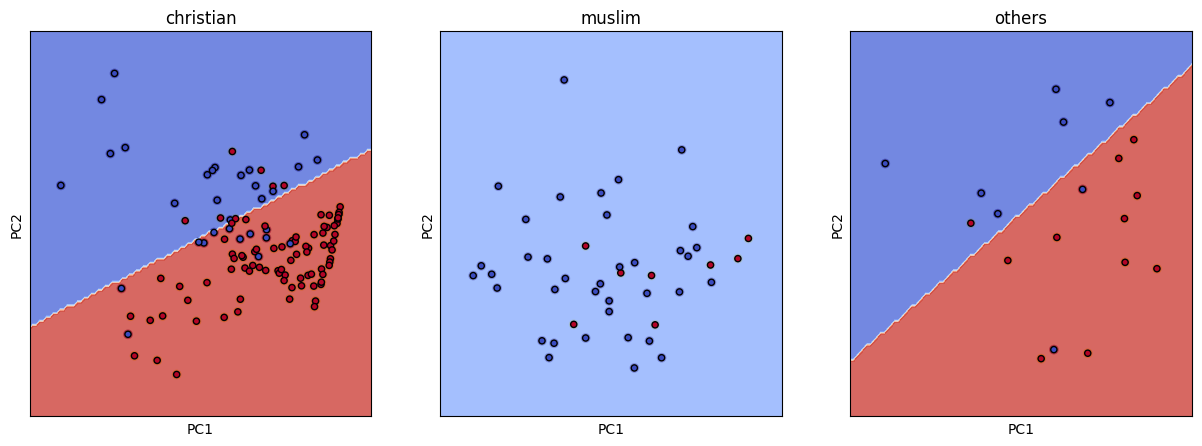

In [220]:
X_only_worldbank = X.drop(columns=["iso3","maj_christian","maj_muslim","maj_unaffiliated","maj_hindu","maj_buddhist","maj_folk","maj_other","maj_jewish"])
X_only_worldbank["democracy"] = y

fig, sub = plt.subplots(1, 3, figsize=(15, 5))

y_by_religion = []
y_preds_by_religion = []
for religion, ax in zip(["christian", "muslim", "others"], sub.flatten()):
    if religion in ["christian","muslim"]:
        X_religion = X_only_worldbank[X_only_worldbank['dominant_religion'] == religion]
        y_religion = X_only_worldbank['democracy'][X_only_worldbank['dominant_religion'] == religion]
    else:
        X_religion = X_only_worldbank[(X_only_worldbank['dominant_religion'] != "christian") & (X_only_worldbank['dominant_religion'] != "muslim")]
        y_religion = X_only_worldbank['democracy'][(X_only_worldbank['dominant_religion'] != "christian") & (X_only_worldbank['dominant_religion'] != "muslim")]
    print(f"Religion: {religion} - N: {len(X_religion)}")
    if len(X_religion) > 1:
        X_religion = X_religion.drop(columns=["dominant_religion"])
        scaler = sk.preprocessing.StandardScaler()
        X_religion_scaled = scaler.fit_transform(X_religion)
        pca = sk.decomposition.PCA(n_components=2)
        X_religion_pca = pca.fit_transform(X_religion_scaled)
        ax.scatter(X_religion_pca[:, 0], X_religion_pca[:, 1], c=y_religion, cmap='viridis')
        ax.set_title(f"{religion}")
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        C = 10.0
        model = sk.svm.SVC(kernel="linear", C=C)
        model = model.fit(X_religion_pca, y_religion)
        disp = sk.inspection.DecisionBoundaryDisplay.from_estimator(
            model,
            X_religion_pca,
            response_method="predict",
            cmap=plt.cm.coolwarm,
            alpha=0.8,
            ax=ax,
            xlabel="PCA1",
            ylabel="PCA2",
        )
        ax.scatter(X_religion_pca[:, 0], X_religion_pca[:, 1], c=y_religion, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
        ax.set_xticks(())
        ax.set_yticks(())
        y_by_religion.append(y_religion)
        y_pred = model.predict(X_religion_pca)
        y_preds_by_religion.append(y_pred)
    

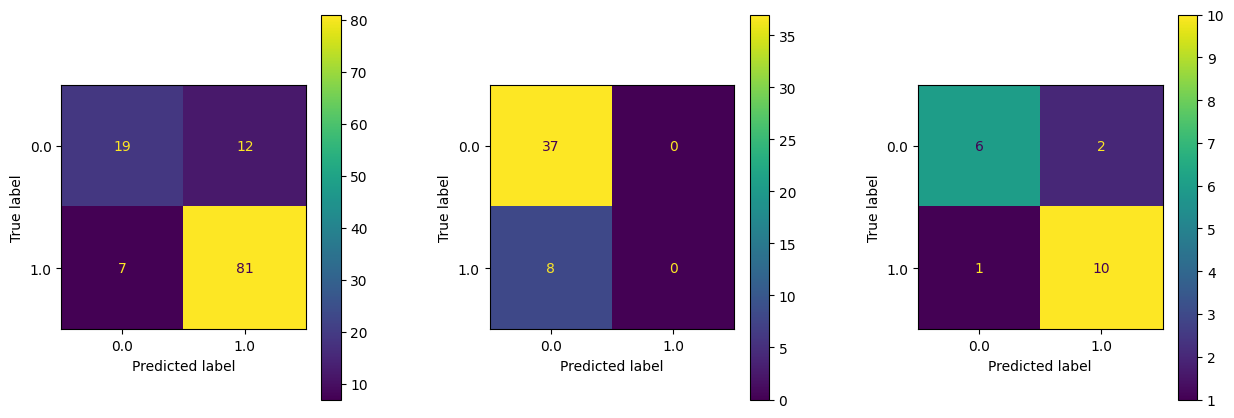

In [221]:
fig, sub = plt.subplots(1, 3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for y_pred, y, ax in zip(y_preds_by_religion, y_by_religion, sub.flatten()):
  cm = sk.metrics.confusion_matrix(y, y_pred)
  disp = sk.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
  disp.plot(ax=ax, cmap='viridis')

plt.show()

The prediction make much more sense when we analyze each religion separately.